# AnDiAnomalousDiffusion

## Task1 - 1D¶

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import Series, test_analysis_alpha

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from hyperopt import hp, tpe, Trials, fmin

random_num = 9

In [11]:
series = Series()
series.read("./Data/Development dataset for Training/task1.txt")

In [12]:
series.differentiate(1, 0.3, 1e-3)

In [13]:
x,y = series.get(range(10000),1)

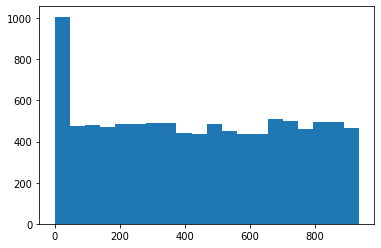

In [14]:
length = [len(i[i!=0]) for i in x]
plt.hist(length, bins=20);

In [15]:
xtr,xtest,ytr,ytest = train_test_split(x,y,test_size=0.3,random_state=random_num)

In [16]:
# Bayesian optimization with 5-fold CV

# Black-box objective function to optimize
def objective(params,n_fold=5):
    
    # We force hyperparameters to be integers
    for parameter_name in ['n_estimators', 'max_depth', 'min_samples_split',"min_samples_leaf"]:
        params[parameter_name] = int(params[parameter_name])

    np.random.seed(2020)
    rf = RandomForestRegressor(random_state=random_num,criterion="mse",n_jobs=-1)
    rf.set_params(**params)
    cv = cross_validate(rf,xtr,ytr,cv=n_fold,scoring="neg_mean_absolute_error",n_jobs=-1)
    mae = cv["test_score"].mean()

    return -mae

# Defining hyperparameter space. quniform returns integer values from a uniform distribution
# quniform(min,max,irrelevant parameter set to 2) == uniform distro between min and max
space = {
    "n_estimators": hp.quniform("n_estimators",1,60,2), 
    "max_depth": hp.quniform("max_depth",1,40,2),
    "min_samples_split": hp.quniform("min_samples_split",2,60,2),
    "min_samples_leaf": hp.quniform("min_samples_leaf",2,40,2)
}

# Defining optimization algorithm (Tree Parzen Estimator)
tpe_algo = tpe.suggest

# Object to save data from optimization process. See more at https://github.com/hyperopt/hyperopt/wiki/FMin
bayes_trials = Trials()

In [17]:
# Function to run bayesian optimization process. max_evals = iterations, the bigger the better, but it takes longer.
best = fmin(fn = objective, space = space, algo = tpe_algo, max_evals = 6, trials = bayes_trials)

100%|██████████| 6/6 [09:21<00:00, 93.63s/trial, best loss: 0.3426767792870158] 


In [18]:
# Best model hyperparameters are saved in best
best

{'max_depth': 32.0,
 'min_samples_leaf': 18.0,
 'min_samples_split': 38.0,
 'n_estimators': 28.0}

In [19]:
# Now we train and test the best model found
rf = RandomForestRegressor(random_state=random_num,criterion="mse",n_jobs=-1)
best = {key:int(val) for key,val in best.items()}
rf.set_params(**best)

rf.fit(xtr,ytr)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=32, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=18,
                      min_samples_split=38, min_weight_fraction_leaf=0.0,
                      n_estimators=28, n_jobs=-1, oob_score=False,
                      random_state=9, verbose=0, warm_start=False)

In [20]:
pred = rf.predict(xtest)

MAE = 0.3393 



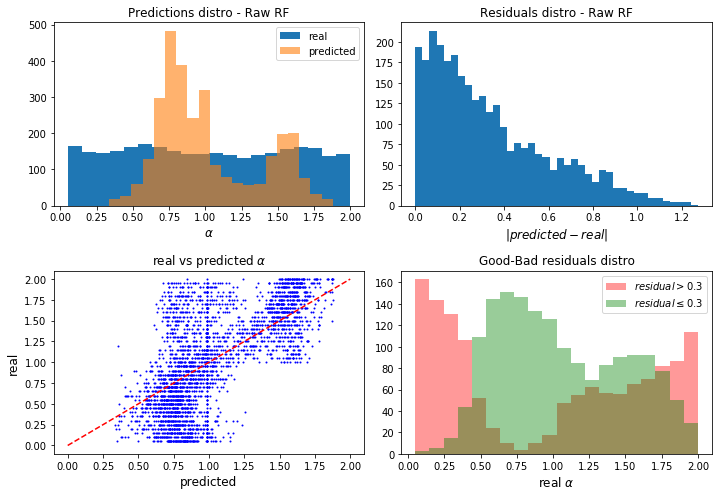

In [21]:
test_analysis_alpha(pred,ytest)

**To do list:**
* ~~Change d~
* ~~View MAE as a function of the serie lengt~~
* Deal with dimensions in differentiation

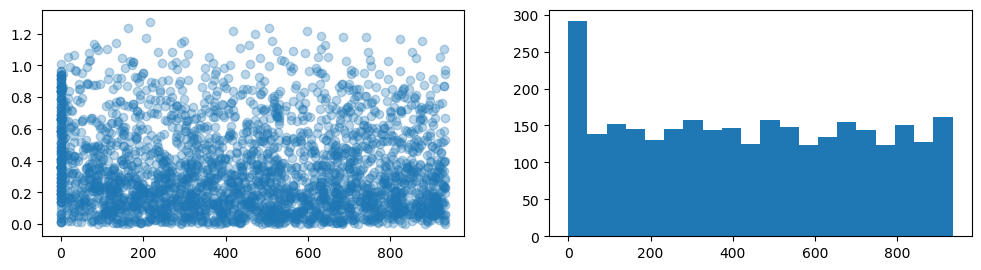

In [22]:
length = [len(i[i!=0]) for i in xtest]
fig = plt.figure(figsize=(12,3), dpi=100)
ax1 = fig.add_subplot(121)
ax1.scatter(length, np.abs(pred-ytest), alpha=0.3)
ax2 = fig.add_subplot(122)
ax2.hist(length, bins=20);